# TP1 vision par ordinateur

## Importation des données et tests

In [34]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os

data_root = "./dataset"
results_root = "./results"
dataset_categories = os.listdir(data_root)
dict_video = {}
for folder in dataset_categories:
    dict_video[folder] = os.listdir(data_root + "/" + folder)

## Flot optique

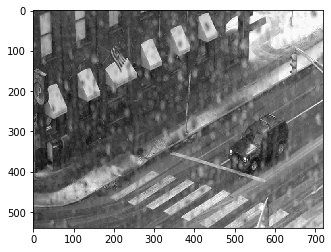

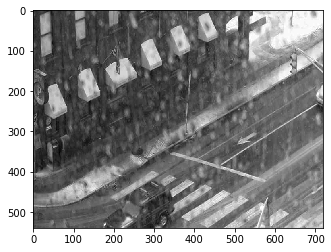

In [2]:
path = data_root + "/" + 'badWeather' + "/" + dict_video['badWeather'][0] + "/" + "input" + "/"

image1 = cv2.imread(path + 'in000100.jpg',cv2.IMREAD_GRAYSCALE)
plt.imshow(image1, cmap = plt.get_cmap('gray'))
plt.show()
image2 = cv2.imread(path + 'in000200.jpg',cv2.IMREAD_GRAYSCALE)
plt.imshow(image2, cmap = plt.get_cmap('gray'))
plt.show()

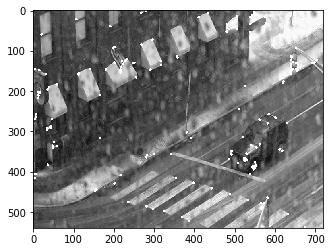

In [3]:
# Extraction de coins. On calculera le flux optique pour les coins.
corners1 = cv2.goodFeaturesToTrack(image1, maxCorners = 2000, qualityLevel = 0.1, minDistance = 3, blockSize = 5 )

temp = np.int32(corners1)
img = np.copy(image1)
for i in range(0, len(corners1)):
    cv2.circle(img,(temp[i,0,0],temp[i,0,1]),3,255,-1)

plt.imshow(img, cmap = plt.get_cmap('gray'))
plt.show()

In [4]:
corners2, st, err = cv2.calcOpticalFlowPyrLK(image1, image2, corners1, None, winSize  = (15,15), maxLevel = 0, 
                                       criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))


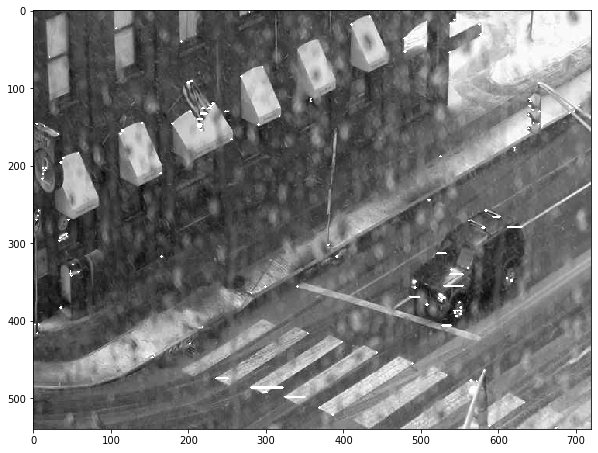

In [5]:
fig1 = plt.figure(figsize = (10,10))
temp1 = np.int32(corners1)
temp2 = np.int32(corners2)
img = np.copy(image1)
for i in range(0, len(corners1)):
    cv2.line(img, (temp1[i,0,0],temp1[i,0,1]),(temp2[i,0,0],temp1[i,0,1]), 255, 2)
plt.imshow(img, cmap = plt.get_cmap('gray'))
plt.show()

In [6]:
# On calcule le flux optique. On obtiendra une valeur de Vx, Vy pour chaque pixel
flot = cv2.calcOpticalFlowFarneback(image1,image2, None, 0.5, 3, 15, 3, 5, 1.2, 0)
print("forme du flot: " + str(flot.shape))

forme du flot: (540, 720, 2)


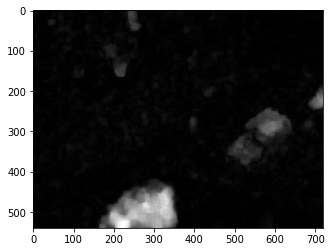

In [7]:
# on recupère la nomre du vecteur V, composé de Vx et Vy,
# en passant en coordonnées polaires
mag, _ = cv2.cartToPolar(flot[...,0], flot[...,1])
# on peut reconstruire notre image en nuance de gris
img = np.uint8(cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX))
plt.imshow(img, cmap = plt.get_cmap('gray'))
plt.show()

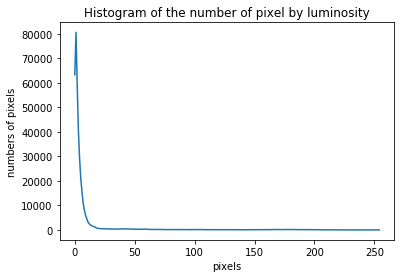

In [8]:
# On essaye de supprimer les pixels presques noirs
histogram = np.bincount(img.flatten())
plt.plot(range(0,255), histogram)
plt.xlabel('pixels')
plt.ylabel('numbers of pixels')
plt.title('Histogram of the number of pixel by luminosity')
plt.show()

On peut voir qu'on peut essayer de supprimer les pixels dont la valeur est inférieur à 40 sans trop prendre de risque.

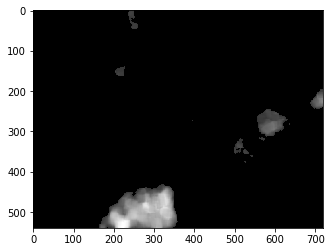

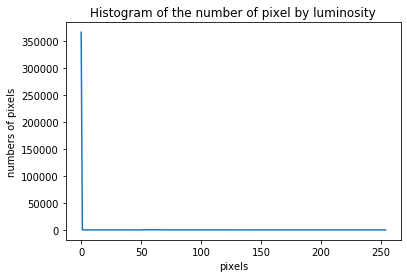

In [9]:
seuil=50

for index, pix in np.ndenumerate(img):
    img[index] = pix if pix > seuil else 0
plt.imshow(img, cmap = plt.get_cmap('gray'))
plt.show()
histogram = np.bincount(img.flatten())
plt.plot(range(0,255), histogram)
plt.xlabel('pixels')
plt.ylabel('numbers of pixels')
plt.title('Histogram of the number of pixel by luminosity')
plt.show()

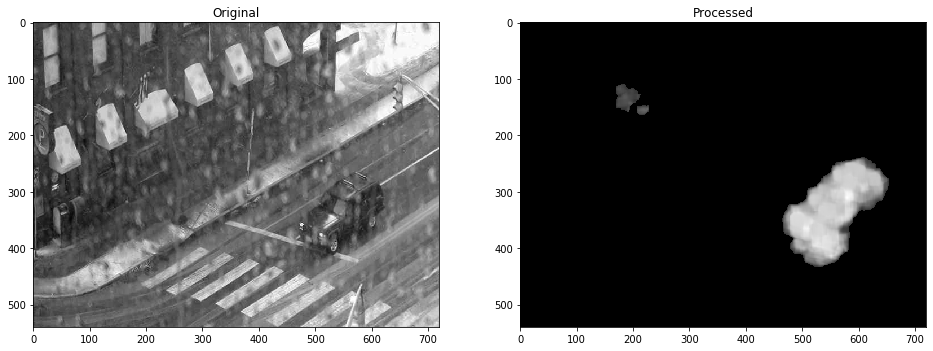

In [10]:
def flot_optique(img1, img2, seuil, print_img=True):
    image1 = cv2.imread(img1,cv2.IMREAD_GRAYSCALE)
    image2 = cv2.imread(img2,cv2.IMREAD_GRAYSCALE)
    # On calcule le flux optique. Cela nous donnera une valeur de Vx, Vy pour chaque pixel
    flot = cv2.calcOpticalFlowFarneback(image1,image2, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    mag, _ = cv2.cartToPolar(flot[...,0], flot[...,1])
    # on peut reconstruire notre image en nuance de gris
    img = np.uint8(cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX))
    for index, pix in np.ndenumerate(img):
        img[index] = pix if pix > seuil else 0
    if print_img:
        fig = plt.figure(figsize=(16,16))
        original = fig.add_subplot(1,2,1)
        original_plot = plt.imshow(image2, cmap = plt.get_cmap('gray'))
        original.set_title('Original')

        processed = fig.add_subplot(1,2,2)
        processed_plot = plt.imshow(img, cmap = plt.get_cmap('gray'))
        processed.set_title('Processed')
        plt.show()
    return img

img = flot_optique(path + 'in000100.jpg', path + 'in000120.jpg', seuil)

### Validation par matrice de confusion

On réalise l'intersection entre les pixels non noir de l'image du flot optique et les pixels non noir du groundthruth

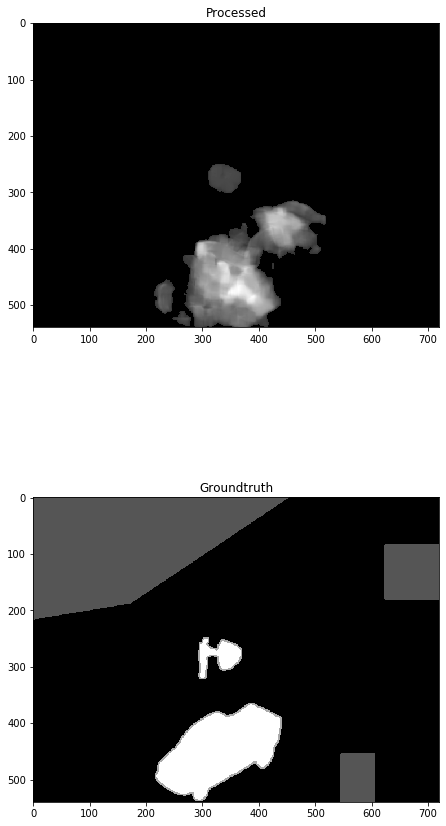

In [40]:
img = flot_optique(path + 'in000500.jpg', path + 'in000510.jpg', seuil, False)
path_gt = data_root + "/" + 'badWeather' + "/" + dict_video['badWeather'][0] + "/" + "groundtruth" + "/"

grd_truth = cv2.imread(path_gt + 'gt000510.png',cv2.IMREAD_GRAYSCALE)

fig = plt.figure(figsize=(16,16))
processed = fig.add_subplot(2,2,1)
processed_plot = plt.imshow(img, cmap = plt.get_cmap('gray'))
processed.set_title('Processed')

gt = fig.add_subplot(2,2,3)
gt_plot = plt.imshow(grd_truth, cmap = plt.get_cmap('gray'))
gt.set_title('Groundtruth')

plt.show()

               numbers  purcentage
True positif     19033           4
False positif    17050           4
True negative   348404          89
False negatif     4313           1

Accuracy: 0.945054012345679
Precision: 0.5274783138874262
Recall: 0.8152574316799451


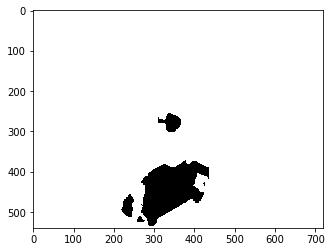

In [39]:
img_merge = np.zeros((img.shape[0], img.shape[1]), dtype='int8')

TP = 0
FP = 0
TN = 0
FN = 0

for index,_ in np.ndenumerate(img_merge):
    if img[index] > 0:
        if grd_truth[index] > 170:
            img_merge[index] = 255
            TP += 1
        else:
            FP += 1
    else:
        if grd_truth[index] > 170:
            FN += 1
        else:
            TN += 1
            
tot = TP+FP+TN+FN
print(pd.DataFrame(
    np.array(
        [[TP, int(TP * 100 /tot)],
         [FP, int(FP * 100 /tot)],
         [TN, int(TN * 100 /tot)],
         [FN, int(FN * 100 /tot)]]),
    index=['True positif', 'False positif', 'True negative', 'False negatif'],
    columns=['numbers', 'purcentage']))

print("\nAccuracy: " + str((TP + TN) / (tot)))
print("Precision: " + str(TP / (TP + FP)))
print("Recall: " + str(TP / (TP + FN)))

plt.imshow(img_merge, cmap = plt.get_cmap('gray'))
plt.show()